In [4]:
# import libraries
from skimage.morphology import erosion
from scipy import stats
from scipy.spatial import distance, distance_matrix
import numpy as np
import pandas as pd
from skimage import measure



<h1>Testing 3D versions of global morphology features</h1>

<h3>First we test the radii features, which worked. Then we test the calliper features which showed some difficulties - see bottom of notebook for explanation and conclusion on calliper features in 3D </h3>

<h2>Testing radii features</h2>

In [5]:
#Reading dataframe
df = pd.read_pickle('test/dataframe.pkl')
df = df.iloc[0:3]
df

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,centroid-0,...,int_sd,kurtosis,skewness,entropy,i80_i20,nhigh_nlow,hc_area_ec_area,hc_area_nuc_area,hc_content_ec_content,hc_content_dna_content
full_label,,,,,,,,,,,,,,,,,,,,,
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_1,1,41180.0,1,181,344,16,249,429,86700.0,7.945119,...,9.461258,-0.625232,-0.216654,4.157515,2.220215,1.007751,0.220944,0.181858,0.398203,0.284796
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_2,2,42281.0,1,330,150,17,423,220,104160.0,8.492396,...,9.156719,-0.705653,-0.199486,3.656943,2.178603,0.967017,0.219175,0.180272,0.393120,0.282187
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_0_nucleus_1,1,41544.0,1,95,287,18,164,358,83283.0,8.667413,...,9.142909,-0.891654,-0.104990,4.202830,2.430162,0.956096,0.238124,0.193411,0.451707,0.311156


In [29]:
#These are the coordinates in 3D of the centroid
df.loc[:,['centroid-0', 'centroid-1', 'centroid-2']]

,centroid-0,centroid-1,centroid-2
full_label,,,
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_1,7.945119,213.757868,385.736013
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_2,8.492396,371.755919,184.916062
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_0_nucleus_1,8.667413,126.91929,324.959007


In [80]:
#Initializing function to scale coordinates for the image resolution
resolution = np.array([0.7, 0.09 ,0.09], dtype=float)

def normalize_coordinates(coords:np.array, resolution:np.array = np.array([0.7, 0.09 ,0.09], dtype=float)):
    return(np.divide(coords,resolution))

def normalize_axis(axis:np.array, resolution:float):
    return(np.divide(axis,resolution))    

In [54]:
#getting boundary pixels

binary_mask = df['image'][0] * 1

bw = binary_mask > 0
edge = np.subtract(bw * 1, erosion(bw) * 1)
(boundary_z, boundary_x, boundary_y) = [np.where(edge > 0)[0], np.where(edge > 0)[1], np.where(edge > 0)[2]]

np.column_stack((boundary_z, boundary_x, boundary_y))


array([[ 0, 25, 31],
       [ 0, 26, 28],
       [ 0, 26, 29],
       ...,
       [14, 50, 38],
       [14, 50, 41],
       [14, 51, 35]], dtype=int64)

In [148]:
def radii_features_3D(mask: np.ndarray, centroid0, centroid1, centroid2, resolution=np.array([0.7, 0.09 ,0.09], dtype=float)):
    """Describing centroid to boundary distances(radii)
    This function obtains radii from the centroid to all the points along the edge and 
    using this computes features that describe the morphology of the given object.
    
    Args:
        mask:(image_matrix) Background pixels are False, foreground True
    """

    binary_mask = mask * 1
    
    # obtain the edge pixels
    bw = binary_mask > 0
    edge = np.subtract(bw * 1, erosion(bw) * 1)
    (boundary_z, boundary_x, boundary_y) = [np.where(edge > 0)[0], np.where(edge > 0)[1], np.where(edge > 0)[2]]
    boundary_z = normalize_axis(axis=boundary_z, resolution=resolution[0])
    boundary_x = normalize_axis(axis=boundary_x, resolution=resolution[1])
    boundary_y = normalize_axis(axis=boundary_y, resolution=resolution[2])
    (centroid0, centroid1, centroid2) = normalize_coordinates(coords=(centroid0, centroid1, centroid2))
   

    # calculate radii
    dist_b_c = np.sqrt(np.square(boundary_z - centroid0) + np.square(boundary_x - centroid1) + np.square(boundary_y - centroid2))
    cords = np.column_stack((boundary_z, boundary_x, boundary_y))
    dist_matrix = distance.squareform(distance.pdist(cords, "euclidean"))
    # Compute features
    feret = dist_matrix[np.triu_indices(dist_matrix.shape[0], k=1)]  # offset

    sns.displot(dist_b_c, kde=True, bins=30)

    feat ={ "min_radius": np.min(dist_b_c),
            "max_radius": np.max(dist_b_c),
            "med_radius": np.median(dist_b_c),
            "avg_radius": np.mean(dist_b_c),
            "mode_radius": stats.mode(np.array(dist_b_c, dtype=int), axis=None, keepdims=True).mode[0],
            "d25_radius": np.percentile(dist_b_c, 25),
            "d75_radius": np.percentile(dist_b_c, 75),
            "std_radius": np.std(dist_b_c),
            "feret_max": np.max(feret)
          }

    return feat, dist_b_c, dist_matrix

In [91]:
import seaborn as sns

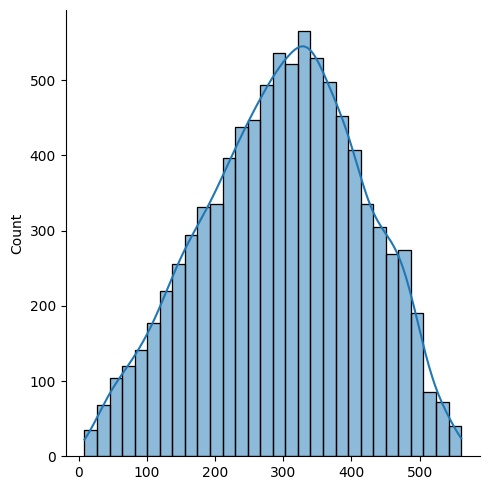

In [153]:
feat, dist_b_c, dist_matrix = radii_features_3D(df['image'][1], df['local_centroid-0'][1], df['local_centroid-1'][1], df['local_centroid-2'][1])

In [3]:
from features import global_morphology

In [4]:
for index, row in df.iterrows():
    df_gm = global_morphology.measure_global_morphometrics(row['image'], [row['local_centroid-0'], row['local_centroid-1'], row['local_centroid-2']])
    dfc = pd.DataFrame(row).transpose()
    dfc = pd.concat([dfc.reset_index(drop=False), df_gm.reset_index(drop=True)], axis=1)
    dfc.rename(columns={'index': 'full_label'}, inplace=True)

dfc

,full_label,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,...,hc_content_dna_content,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,d75_radius,std_radius,feret_max
0,PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_0_nucleus_1,1,41544.0,1,95,287,18,164,358,83283.0,...,0.311156,2.614553,6.066301,4.176957,4.182957,4,3.524447,4.79946,0.766739,11.793579


<h2>Testing Calliper features </h2>

In [3]:
from scipy.ndimage import rotate
import pandas as pd
from matplotlib import pyplot as plt


In [6]:
df = pd.read_pickle('test/dataframe.pkl')
df = df.iloc[0:3]
df

,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,centroid-0,...,int_sd,kurtosis,skewness,entropy,i80_i20,nhigh_nlow,hc_area_ec_area,hc_area_nuc_area,hc_content_ec_content,hc_content_dna_content
full_label,,,,,,,,,,,,,,,,,,,,,
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_1,1,41180.0,1,181,344,16,249,429,86700.0,7.945119,...,9.461258,-0.625232,-0.216654,4.157515,2.220215,1.007751,0.220944,0.181858,0.398203,0.284796
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_6_nucleus_2,2,42281.0,1,330,150,17,423,220,104160.0,8.492396,...,9.156719,-0.705653,-0.199486,3.656943,2.178603,0.967017,0.219175,0.180272,0.393120,0.282187
PBMCs_Fixed_GammaH2AX_LaminA_DAPI_H96_0_nucleus_1,1,41544.0,1,95,287,18,164,358,83283.0,8.667413,...,9.142909,-0.891654,-0.104990,4.202830,2.430162,0.956096,0.238124,0.193411,0.451707,0.311156


In [57]:
def calliper_sizes(binary_mask: np.ndarray, angular_resolution:int = 10, resolution = [0.7, 0.09, 0.09]):
    """Obtains the min and max Calliper distances
    
    This functions calculates min and max the calliper distances by rotating the image
    by the given angular resolution
    
    Args: 
        binary_mask:(image_arrray)
        angular_resolution:(integer) value between 1-179 to determine the number of rotations
    """

    def scale_calliper(curr_calliper, angle1, angle2, resolution):
        angle1_r, angle2_r = np.deg2rad(angle1), np.deg2rad(angle2)

        delta_z_scaled = np.multiply(np.multiply(curr_calliper, np.multiply(np.sin(angle1_r), np.cos(angle2_r))), resolution[0])
        delta_x_scaled = np.multiply(np.multiply(curr_calliper, np.sin(angle2_r)), resolution[1])
        delta_y_scaled = np.multiply(np.multiply(curr_calliper, np.multiply(np.cos(angle1_r), np.cos(angle2_r))), resolution[2])

        curr_calliper = np.sqrt(np.square(delta_z_scaled) + np.square(delta_x_scaled) + np.square(delta_y_scaled))
        print(f'Angle1:{angle1}, Angle2:{angle2}, Calliper:{curr_calliper}, Delta_z:{delta_z_scaled}, Delta_x:{delta_x_scaled}, Delta_y:{delta_y_scaled}')

        return (curr_calliper)


    img = binary_mask > 0
    callipers = []

    for angle1 in range(0, 180, angular_resolution):
        rot_img1 = rotate(img, angle1, axes=(0,2)) #0,1 works - 0,2 is correct
        for angle2 in range(0, 180, angular_resolution):
            rot_img2 = rotate(rot_img1, angle2, axes=(1,2)) #0,2 works - 1,2 is correct
            curr_calliper = (np.max(np.sum(rot_img2, axis=2)))
            print(f'Unscaled Calliper {curr_calliper}')
            callipers.append(scale_calliper(curr_calliper, angle1, angle2, resolution))
        
    feat = { "min_calliper": np.min(callipers), 
             "max_calliper": np.max(callipers),
             "smallest_largest_calliper": np.min(callipers)/np.max(callipers)
           }
    
    return feat

In [8]:
img = df['image'][0]
img.shape

(15, 68, 85)

In [107]:
calliper_sizes(img)

{'min_calliper': 2.7078523628532367,
 'max_calliper': 46.9,
 'smallest_largest_calliper': 0.05773672415465324}

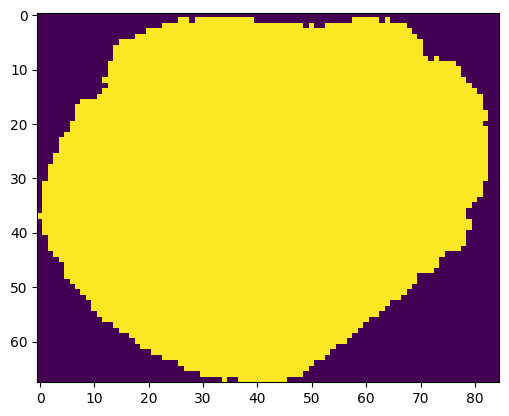

In [91]:
plt.imshow(img[8, :, :])

In [96]:
imgr = rotate(img, 90, axes=(1,2), reshape=True)

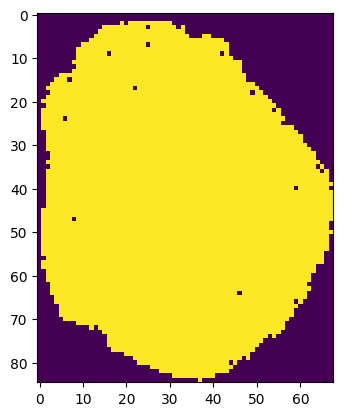

In [97]:
plt.imshow(imgr[8, :, :])

In [100]:
np.max(np.sum(imgr,axis=2))

67

<h4>Test case of a cube where we know max calliper </h4>

In [93]:
cube = np.ones((10, 20, 20), dtype=bool)
resolution = [2, 1, 1]
shape_um = np.multiply(cube.shape, resolution)

print(f'Cube shape pixels: {cube.shape}')
print(f'Cube shape um: {shape_um}')
print(f'Max Calliper of Cube in pixels: {np.sqrt(np.sum(np.square(cube.shape)))}')
print(f'Max Calliper of Cube in um: {np.sqrt(np.sum(np.square(shape_um)))}')

#cube = np.pad(cube, 5)
cube.shape


Cube shape pixels: (10, 20, 20)
Cube shape um: [20 20 20]
Max Calliper of Cube in pixels: 30.0
Max Calliper of Cube in um: 34.64101615137755


(10, 20, 20)

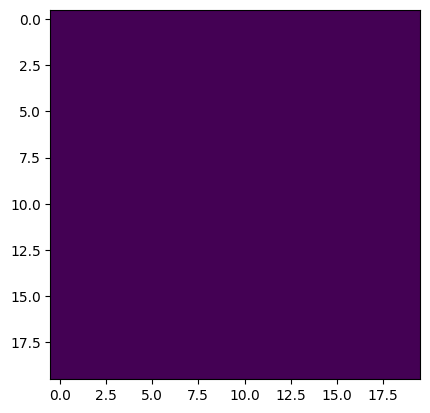

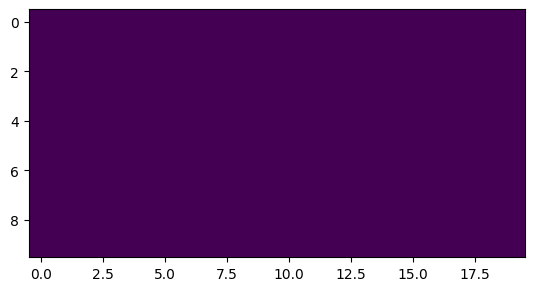

In [94]:
plt.imshow(cube[5, :, :])
plt.show()
plt.imshow(cube[:, 10, :])

In [95]:
cube_r = rotate(cube, 45, axes=(1,2))
cube_r = rotate(cube_r, 45, axes=(0,2))
cube_r.shape

(27, 28, 27)

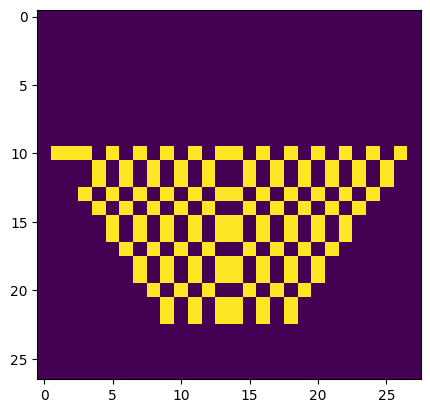

In [97]:
plt.imshow(cube_r[:, :, 10])

In [62]:
calliper_sizes(cube, angular_resolution=10)

Unscaled Calliper 100
Angle1:0, Angle2:0, Calliper:9.0, Delta_z:0.0, Delta_x:0.0, Delta_y:9.0
Unscaled Calliper 101
Angle1:0, Angle2:10, Calliper:9.09, Delta_z:0.0, Delta_x:1.5784619349923965, Delta_y:8.95190247488097
Unscaled Calliper 106
Angle1:0, Angle2:20, Calliper:9.54, Delta_z:0.0, Delta_x:3.2628721673268797, Delta_y:8.964667602297565
Unscaled Calliper 115
Angle1:0, Angle2:30, Calliper:10.35, Delta_z:0.0, Delta_x:5.174999999999999, Delta_y:8.963362929168941
Unscaled Calliper 129
Angle1:0, Angle2:40, Calliper:11.609999999999998, Delta_z:0.0, Delta_x:7.46276414846072, Delta_y:8.893775984611334
Unscaled Calliper 130
Angle1:0, Angle2:50, Calliper:11.7, Delta_z:0.0, Delta_x:8.962719984492043, Delta_y:7.5206150333325095
Unscaled Calliper 115
Angle1:0, Angle2:60, Calliper:10.35, Delta_z:0.0, Delta_x:8.96336292916894, Delta_y:5.175000000000001
Unscaled Calliper 106
Angle1:0, Angle2:70, Calliper:9.54, Delta_z:0.0, Delta_x:8.964667602297565, Delta_y:3.2628721673268806
Unscaled Calliper 101

{'min_calliper': 3.368080181344632,
 'max_calliper': 11.7,
 'smallest_largest_calliper': 0.2878701009696267}

In [72]:
calliper_sizes(cube, angular_resolution=45)

Unscaled Calliper 20
Angle1:0, Angle2:0, Calliper:1.7999999999999998, Delta_z:0.0, Delta_x:0.0, Delta_y:1.7999999999999998
Unscaled Calliper 12
Angle1:0, Angle2:45, Calliper:1.08, Delta_z:0.0, Delta_x:0.7636753236814714, Delta_y:0.7636753236814714
Unscaled Calliper 20
Angle1:0, Angle2:90, Calliper:1.7999999999999998, Delta_z:0.0, Delta_x:1.7999999999999998, Delta_y:1.1021821192326179e-16
Unscaled Calliper 12
Angle1:0, Angle2:135, Calliper:1.0799999999999998, Delta_z:-0.0, Delta_x:0.7636753236814714, Delta_y:-0.7636753236814713
Unscaled Calliper 7
Angle1:45, Angle2:0, Calliper:3.493343670468166, Delta_z:3.4648232278140827, Delta_x:0.0, Delta_y:0.4454772721475249
Unscaled Calliper 4
Angle1:45, Angle2:45, Calliper:1.43429425153976, Delta_z:1.4000000000000001, Delta_x:0.2545584412271571, Delta_y:0.18000000000000002
Unscaled Calliper 20
Angle1:45, Angle2:90, Calliper:1.7999999999999998, Delta_z:6.061692393648454e-16, Delta_x:1.7999999999999998, Delta_y:7.79360450611944e-17
Unscaled Calliper

{'min_calliper': 1.0799999999999998,
 'max_calliper': 7.0,
 'smallest_largest_calliper': 0.15428571428571428}

In [66]:
np.sqrt(100**2 + 100**2 + 10**2)

141.77446878757826

In [49]:
calliper_sizes(cube, angular_resolution=90)

Unscaled Calliper 100
Angle1:0, Angle2:0, Calliper:9.0, Delta_z:0.0, Delta_x:0.0, Delta_y:9.0
Unscaled Calliper 100
Angle1:0, Angle2:90, Calliper:9.0, Delta_z:0.0, Delta_x:9.0, Delta_y:5.51091059616309e-16
Unscaled Calliper 10
Angle1:90, Angle2:0, Calliper:7.0, Delta_z:7.0, Delta_x:0.0, Delta_y:5.5109105961630896e-17
Unscaled Calliper 100
Angle1:90, Angle2:90, Calliper:70.0, Delta_z:70.0, Delta_x:5.51091059616309e-16, Delta_y:3.374459510989179e-32


{'min_calliper': 7.0, 'max_calliper': 70.0, 'smallest_largest_calliper': 0.1}

In [193]:
cube_r_0_45 = rotate(cube, 5, axes=(1,2))
cube_r_45_45 = rotate(cube, 5, axes=(0,2))
np.max(np.sum(cube_r_45_45, axis=2))

98

(19, 100, 100)


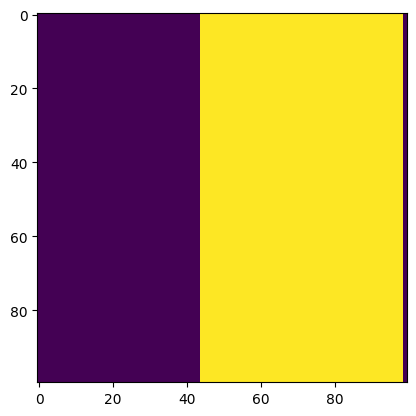

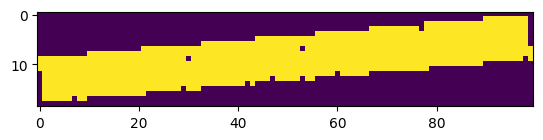

In [195]:
print(cube_r_45_45.shape)
plt.imshow(cube_r_45_45[5, :, :])
plt.show()
plt.imshow(cube_r_45_45[:, 50, :])
plt.show()

In [70]:
def scale_calliper(curr_calliper, angle1, angle2, resolution):
        angle1_r, angle2_r = np.deg2rad(angle1), np.deg2rad(angle2)

        delta_z_scaled = np.multiply(np.multiply(curr_calliper, np.multiply(np.sin(angle1_r), np.cos(angle2_r))), resolution[0])
        delta_x_scaled = np.multiply(np.multiply(curr_calliper, np.sin(angle2_r)), resolution[1])
        delta_y_scaled = np.multiply(np.multiply(curr_calliper, np.multiply(np.cos(angle1_r), np.cos(angle2_r))), resolution[2])

        curr_calliper = np.sqrt(np.square(delta_z_scaled) + np.square(delta_x_scaled) + np.square(delta_y_scaled))
        print(f'Angle1:{angle1}, Angle2:{angle2}, Calliper:{curr_calliper}, Delta_z:{delta_z_scaled}, Delta_x:{delta_x_scaled}, Delta_y:{delta_y_scaled}')

        return (curr_calliper)

scale_calliper(30, 45, 45, resolution)

Angle1:45, Angle2:45, Calliper:39.686269665968865, Delta_z:30.000000000000007, Delta_x:21.213203435596427, Delta_y:15.000000000000004


39.686269665968865

<h3> Conclusion </h3>
Calculating the amount of contribution of each axis of the object to the calliper and recalculating the calliper with the scaled contribution of the axis doesn't quite add up since one axis will always not be affected by the first rotation and hence not be attributed the correct amount. Maybe a more complex calculation could solve it.
 
One approach would be to upsample the z-axis to then be able to scale the calliper distance by the same amount for each axis (caliper * resolution)

However, the 3d rotation around two angles of the image introduces too many holes to reliably calculate the calliper even in pixel scaling.





<h4> Alternative Approach </h4>

An alternative approach would be to rotate a mask of a 2D plane with two angels, and for each angle-pair scan a certain offset of the plane. 
This approach is like getting 2D scans of the image for different angle-pairs.

The 2D plane could be rotated by a given rotation matrix and then iterated over offsets. For each iteration, a 2D slice of the image would be taken by applying the 2D plane onto the image with a certain threshold to account for the difference in coordinates (float) and pixels (int).
The resulting scan of the image would then be a 2D plane in the 3D space of the image and could be rotated onto the xy-plane by applying the inverse of the rotation matrix to it.
The representation of the slice on the xy-plane now enables to use the original approach for calliper calculation in 2D.

However, calculating this at a satisfying resolution would take up a lot of computation time hence the testing and trouble shooting of the coding process would also take a long time. Considering the shape of the nuclei in our dataset and the importance of these features in other projects, the implementation of this approach will not be prioritised.